# `numpy` Neural Networks: Weight Regularization & Dropout

So we've gotten a lot better at training. Now we need to avoid over training! We'll check out two techniques for this: weight regularization and dropout. First, generating the data and the most training functions from the previous notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

I've pushed the activations, cost functions, and model initialization functions to `common.py`.

In [2]:
from common import *  # bad form but I know what's in there, only funcs from previous notebooks

Make a much smaller dataset to demonstrate overfitting.

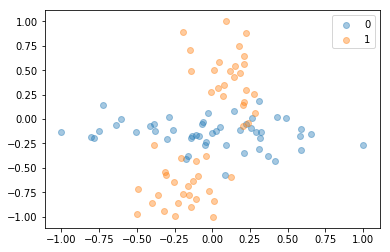

In [3]:
n_samples = 100

np.random.seed(1234)
X0 = np.random.normal(loc=[0, 0], scale=[2, 0.5], size=(int(n_samples / 2), 2))
X11 = np.random.normal(loc=[1, 2], scale=[0.5, 1], size=(int(n_samples / 4), 2))
X12 = np.random.normal(loc=[0, -2], scale=[0.5, 1], size=(int(n_samples / 4), 2))
X1 = np.vstack([X11, X12])
X = np.vstack([X0, X1])

# rescale between -1 and 1
X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X = 2*X - 1

y0 = np.zeros(shape=(int(n_samples / 2), 1))
y1 = np.ones(shape=(int(n_samples / 2), 1))
yhat = np.vstack([y0, y1])

# shuffle the data
inds = np.random.permutation(np.arange(n_samples))
X = X[inds]
yhat = yhat[inds]

X0 = X[(yhat==0).reshape(-1)]
X1 = X[(yhat==1).reshape(-1)]

plt.scatter(*X0.T, label='0', alpha=0.4); plt.scatter(*X1.T, label='1', alpha=0.4)
plt.legend();

In [4]:
def forwardn(x0, w, b):
    n_layers = len(w)
    x_prev = x0
    for l in range(1, n_layers):
        x_l = relu(np.dot(x_prev, w[l]) + b[l].T)  # output of a hidden layer
        x_prev = x_l
    return sig(np.dot(x_prev, w[n_layers]) + b[n_layers].T)  # output of output layer

def backward_mom(X0, w, b, y, yhat, dw, db, alpha, beta):
    n_layers = len(w)
    batch_size = len(yhat)
    z = {}
    x = {0:X0}
    delta = {}

    # x and z values for calculating derivatives
    for l in range(1, n_layers+1):
        z[l] = np.matmul(x[l-1], w[l]) + b[l].T
        x[l] = relu(z[l])
            
    # deltas and updates
    for l in range(n_layers, 0, -1):  # start with last layer and move backward
        if l == n_layers:  # base case
            delta[l] = (dJ_dy(y, yhat) * dsig_dz(z[n_layers])).T
        else:  # recursive case
            delta[l] =  np.matmul(w[l+1], delta[l+1]) * drelu_dz(z[l]).T
            
        # Updates from backprop
        dw_new = np.matmul(delta[l], x[l-1]).T / batch_size
        db_new = delta[l].mean(axis=1, keepdims=True)
        
        # Exp. weighted average
        dw[l] = beta*dw[l] + (1-beta)*dw_new
        db[l] = beta*db[l] + (1-beta)*db_new
        
        # update weights and biases
        w[l] -= alpha * dw[l]
        b[l] -= alpha * db[l]
    
    return w, b, dw, db

def train_dec(X, yhat, shape, alpha, n_epoch, batch_size, beta, gamma):
    n_samples = X.shape[0]
    n_input = X.shape[1]
    
    # keep track of performance during training
    costs = np.zeros(shape=(n_epoch,1))

    # random nonzero initialization
    w,b = init_model(shape, seed=1234)

    # initialize dw and db to zero
    dw = {l:np.zeros_like(wl) for l,wl in w.items()}
    db = {l:np.zeros_like(bl) for l,bl in b.items()}
    
    alph = alpha
    
    for epoch in range(n_epoch):
        for i in range(0, n_samples, batch_size):
            X_batch = X[i:i+batch_size,:]
            yh = yhat[i:i+batch_size]
            
            y = forwardn(X_batch, w, b)  # prediction for mini-batch
            w, b, dw, db = backward_mom(X_batch, w, b, y, yh, dw, db, alph, beta)  # take step
        
        # Decay the learning rate
        alph *= (1 - gamma)
        
        # ### Some niceness to see our progress
        # Calculate total cost after epoch
        predictions = forwardn(X, w, b)  # predictions for entire set
        costs[epoch] = np.mean(J(predictions, yhat))  # mean cost per sample
        # report progress
        accuracy = np.mean(predictions.round() == yhat)  # current accuracy on entire set
        print('\rTraining accuracy after epoch {}: {:.4%}'.format(epoch, accuracy), end='')
            
    print()    
    return w, b, costs

Do demonstrate overfitting, we train an unnecessarily large network for thousands of epochs to solve this tiny problem. We use learning rate decay and momentum to really get close to the minimum, and speed things up by using mini-batches. 

Training accuracy after epoch 1999: 97.0000%
CPU times: user 6.71 s, sys: 860 ms, total: 7.57 s
Wall time: 7.07 s


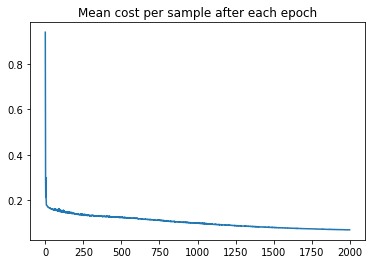

In [5]:
batch_size = 16
shape = (2,64,128,1)
alpha = 0.1
gamma = 0.0005
beta = 0.9
n_epoch = 2000
%time w, b, costs = train_dec(X, yhat, shape, alpha, n_epoch, batch_size, beta, gamma)
plt.plot(costs)
plt.title('Mean cost per sample after each epoch');

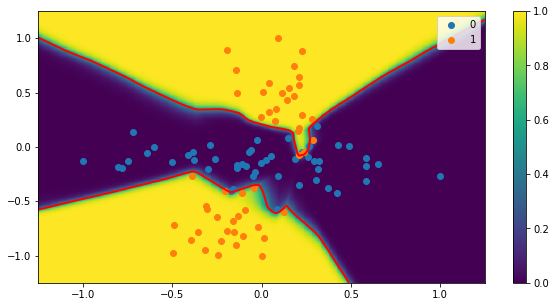

In [6]:
x1 = np.linspace(-1.25,1.25,500)
x2 = np.linspace(-1.25,1.25,500)
fun_map = np.empty((x1.size, x2.size))
for n,i in enumerate(x1):
    for m,j in enumerate(x2):
        fun_map[m,n] = forwardn([i,-j], w, b)

X0 = X[(yhat==0).reshape(-1)]
X1 = X[(yhat==1).reshape(-1)]

plt.figure(figsize=(10,5))
plt.imshow(fun_map, extent=[x1.min(), x1.max(), x2.min(), x2.max()], 
           vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.contour(x1, -x2, fun_map, levels=[0.5], colors=['r'], linewidths=2)
plt.scatter(*X0.T, label='0', alpha=1); plt.scatter(*X1.T, label='1', alpha=1)
plt.xlim([x1.min(),x1.max()]); plt.ylim([x2.min(),x2.max()]);
plt.legend();

Looking at the red decision boundary, we see quite a bit of distortion caused by individual datapoints close to the boundary. In particular the "wiggly" form along the top of the lower boundary is a sure sign of overfitting. 

# Weight Regularization

To help reduce overtraining, one approach is to penalize the size of the model's weights in the cost function. Large weights can lead to very sharp derivatives, or to over-reliance on one feature. To do this, we define a new cost function, which contains an extra term. There are a few different ways of doing this, but most commonly one can minimize either the sum of the absolute value of the weights ($L_1$ regularization) or the sum of their squares ($L_2$ regularization). We will do $L_2$ regularization, penalizing the sum-of-squares of all the weights. The amount of regularization is controlled by the new parameter $\lambda$:

$$ J_{reg}(y,\hat y, w, \lambda) = J(y,\hat y) + \frac{\lambda}{2} \sum_{\ell,i,j} (w^\ell_{ij})^2 $$

Note that the partial derivative with respect to $y$ remains unchanged, but since there is now an explicit $w$ dependence, we will need to incorporate this into $dw$. In matrix notation,

$$ \frac{\partial J_{reg}}{\partial y} = \frac{\partial J}{\partial y} $$

$$ \frac{\partial J_{reg}}{\partial w^\ell} = \lambda w^\ell$$


In [7]:
def Jreg(y, yhat, w, lam):
    eps = 1e-6
    cost_term = -(yhat*np.log(y+eps) + (1-yhat)*np.log(1-y+eps)) # Same as J
    reg_term = 0.5*lam*sum([(w[l]**2).sum() for l in w])  # Weight regularization
    return cost_term + reg_term

def dJreg_dy(y, yhat, w, lam):  # Same as dJ_dy, just redefine to match parameters of Jreg
    eps = 1e-8
    return (1-yhat)/(1-y+eps) - yhat/(y+eps)

In [8]:
y = np.linspace(0,1, num=5)
yh = np.ones(5)
print('y     :', *[f'{i:>8.3f}' for i in y])
print('y_hat :', *[f'{i:>8.3f}' for i in yh])
print()
print('J     :', *[f'{i:>8.3f}' for i in J(y,yh).T])
print('J_reg :', *[f'{i:>8.3f}' for i in Jreg(y, yh, w, 0.01).T])

y     :    0.000    0.250    0.500    0.750    1.000
y_hat :    1.000    1.000    1.000    1.000    1.000

J     :   18.421    1.386    0.693    0.288   -0.000
J_reg :   25.096   12.667   11.974   11.568   11.280


Note that $J_{reg}$ will always have a higher value than $J$ since we have added an extra non-negative term. This means that the cost functions are not directly comparable to each other!

We define a new training function that utilizes the new cost function and takes `lam` as a parameter, and train a new model with the same settings as before, but adding weight regularization with $\lambda = 0.01$

In [9]:
def backward_reg(X0, w, b, y, yhat, dw, db, alpha, beta, lam):
    n_layers = len(w)
    batch_size = len(yhat)
    z = {}
    x = {0:X0}
    delta = {}

    # x and z values for calculating derivatives
    for l in range(1, n_layers+1):
        z[l] = np.matmul(x[l-1], w[l]) + b[l].T
        x[l] = relu(z[l])
            
    # deltas and updates
    for l in range(n_layers, 0, -1):  # start with last layer and move backward
        if l == n_layers:  # base case
            delta[l] = (dJreg_dy(y, yhat, w, lam) * dsig_dz(z[n_layers])).T
        else:  # recursive case
            delta[l] =  np.matmul(w[l+1], delta[l+1]) * drelu_dz(z[l]).T
            
        # dw_new now with extra term from explicit w dependence!
        dw_new = (np.matmul(delta[l], x[l-1]).T / batch_size) + lam*w[l]  
        db_new = delta[l].mean(axis=1, keepdims=True)
        
        # Exp. weighted average
        dw[l] = beta*dw[l] + (1-beta)*dw_new
        db[l] = beta*db[l] + (1-beta)*db_new
        
        # update weights and biases
        w[l] -= alpha * dw[l]
        b[l] -= alpha * db[l]
    
    return w, b, dw, db

def train_reg(X, yhat, shape, alpha, n_epoch, batch_size, beta, gamma, lam):
    n_samples = X.shape[0]
    n_input = X.shape[1]
    
    # keep track of performance during training
    costs = np.zeros(shape=(n_epoch,1))

    # random nonzero initialization
    w,b = init_model(shape, seed=(1234))
    
    # initialize dw and db to zero
    dw = {l:np.zeros_like(wl) for l,wl in w.items()}
    db = {l:np.zeros_like(bl) for l,bl in b.items()}
    
    alph = alpha

    for epoch in range(n_epoch):
        for i in range(0, n_samples, batch_size):
            X_batch = X[i:i+batch_size,:]
            yh = yhat[i:i+batch_size]
            
            y = forwardn(X_batch, w, b)  # prediction for mini-batch
            w, b, dw, db = backward_reg(X_batch, w, b, y, yh, dw, db, alph, beta, lam)  # take step
            
        # Decay the learning rate
        alph *= (1 - gamma)
        
        # ### Some niceness to see our progress
        # Calculate total cost after epoch
        predictions = forwardn(X, w, b)  # predictions for entire set
        costs[epoch] = np.mean(Jreg(predictions, yhat, w, lam))  # mean cost per sample
        # report progress
        accuracy = np.mean(predictions.round() == yhat)  # current accuracy on entire set
        print('\rTraining accuracy after epoch {}: {:.4%}'.format(epoch, accuracy), end='')
            
    print()    
    return w, b, costs

Training accuracy after epoch 1999: 91.0000%
CPU times: user 6.92 s, sys: 871 ms, total: 7.79 s
Wall time: 7.31 s


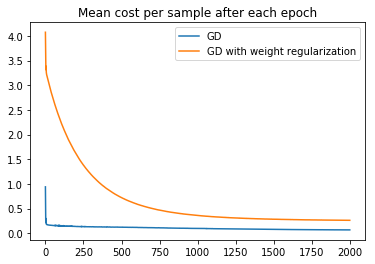

In [10]:
batch_size = 16
shape = (2,64,128,1)
alpha = 0.1
gamma = 0.0005
beta = 0.9
n_epoch = 2000
lam = 0.003
%time w_reg, b_reg, costs_reg = train_reg(X, yhat, shape, alpha, n_epoch, batch_size, beta, gamma, lam)
plt.plot(costs, label='GD')
plt.plot(costs_reg, label='GD with weight regularization')
plt.legend()
plt.title('Mean cost per sample after each epoch');

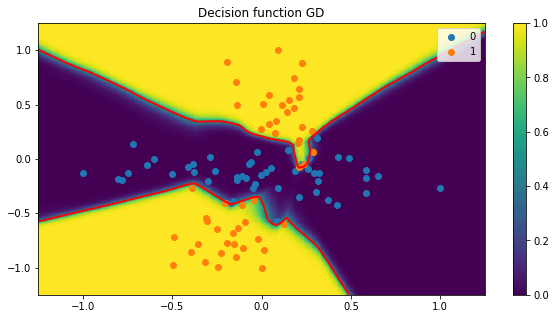

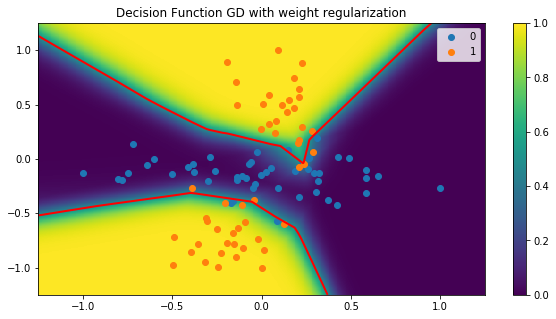

In [11]:
fun_map_reg = np.empty((x1.size, x2.size))
for n,i in enumerate(x1):
    for m,j in enumerate(x2):
        fun_map_reg[m,n] = forwardn([i,-j], w_reg, b_reg)

plt.figure(figsize=(10,5))
plt.imshow(fun_map, extent=[x1.min(), x1.max(), x2.min(), x2.max()], 
           vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.scatter(*X0.T, label='0', alpha=1); plt.scatter(*X1.T, label='1', alpha=1)
plt.legend()
plt.contour(x1, -x2, fun_map, levels=[0.5], colors=['r'], label='Decision boundary', linewidths=2)
plt.title('Decision function GD')
plt.show();

plt.figure(figsize=(10,5))
plt.imshow(fun_map_reg, extent=[x1.min(), x1.max(), x2.min(), x2.max()], 
           vmin=0, vmax=1, aspect='auto')
plt.colorbar();
plt.contour(x1, -x2, fun_map_reg, levels=[0.5], colors=['r'], label='Decision boundary', linewidths=2)
plt.title('Decision Function GD with weight regularization');
plt.scatter(*X0.T, label='0', alpha=1); plt.scatter(*X1.T, label='1', alpha=1)
plt.legend();

We see that regularizing the weights has had all the expected effects:

* The cost function remains higher in value than its unregularized counterpart (not a concern because it is actually a different function)
* The gradients are much less steep than in the unregularized model

The less shallower gradients also cause the "wiggles" in the bottom part of the heatmap, which are a result of overfitting our small dataset, to blur and smooth out, which is exactly what we were hoping to see.

It remains to be seen if the weights are also indeed lower than the unregularized weights. We plot them all on a scatter plot to investigate:

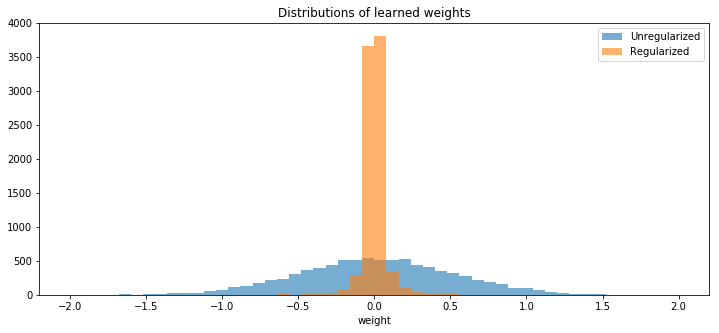

In [12]:
all_w = np.hstack([w[l].reshape(-1) for l in w])
all_w_reg = np.hstack([w_reg[l].reshape(-1) for l in w_reg])

plt.figure(figsize=(12,5))
plt.hist(all_w, label='Unregularized', alpha=0.6, bins=50, range=(-2,2))
plt.hist(all_w_reg, label='Regularized', alpha=0.6, bins=50, range=(-2,2))
plt.title('Distributions of learned weights'); plt.xlabel('weight');
plt.legend();

The distributions of learned weights is very different. With regularization, the distribution is very sharply peaked around zero. This suggests that our model is actually much larger than necessary, since many of the connections are redundant, and with the incentive to get rid of them, the model can do so while still maintaining reasonable accuracy.

# Dropout

Dropout, introduced in [this paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf), takes a different approach to regularization. The basic idea is, at each training step, to randomly remove a portion of the units in the network and only update the remaining connections via backprop. Some reasoning behind doing this is:

* It's possible that several units can learn "bad" features that compensate for each other to still produce an okay result. This situation is very brittle and although it may work on the training set, on a test set it's unlikely that the specific conditions required to balance these bad units will still be present, leading to poor generalization. Dropout ensures that units can't depend on each other since there is always a good chance that each unit might disappear. 

* Ideally we would like to make an ensemble of all possible networks and average over their predictions, weighted by their accuracy. This is clearly not feasible for computational reasons. Using dropout, we instead sample a lot of different sub-networks and train those, and average over them when making predictions.

When making predictions, we don't do dropout, but use all of our connections. This has the effect of averaging over all the random sub-networks that we trained using dropout.

When implementing dropout it's important to pay attention to scaling issues. Call the fraction of units for each that we keep $p^\ell$. In other words, for layer $\ell$, each unit is dropped (output multiplied by zero) with probability $1-p^\ell$. Since we drop a bunch of the units, the average magnitude of the input to the following layer, $z^{\ell+1}$, will be reduced by the same amount, simply because a bunch of the input terms will be zero. For this reason, it is important to multiply each layer's output $x^\ell$ by $1/p^\ell$. Otherwise, the weights will be learned with the expectation that $z^\ell$ has a particular scale, and at prediction time (when we keep all the units), $z^\ell$ will get contributions from all the units and so will be much larger.

To implement this practically, we first write a function to make a random mask for each layer. It takes two variables: the `shape` of the network, and the probability of keeping a unit for each layer, a tuple which we will call `p`. It outputs an array that we can use to multiply $x^\ell$. The elements of the mask have value `1/p[i]` with probability `p[i]`, and otherwise zero. Since each layer is a different size, we take the same approach as with `w`  and `b` and store it in a dictionary. 

In [13]:
def make_mask(p, shape):
    mask = {}
    for layer, size in enumerate(shape):
        # 1 with prob b[layer] = binomial(1 trial, probability p[layer])
        # then divide by p[layer] for scaling
        mask[layer] = np.random.binomial(1, p[layer], size=(1, size)) / p[layer]
        
    return mask

We want to keep all the input data and the output, so the first and last elements of `p` are always 1.

In [14]:
make_mask(p=(1,0.5,0.2,1), shape=(2,5,10,1))

{0: array([[1., 1.]]),
 1: array([[2., 0., 0., 2., 0.]]),
 2: array([[0., 5., 0., 0., 0., 0., 0., 5., 0., 0.]]),
 3: array([[1.]])}

During training, we need to generate a new mask at each update step, but apply the same mask for both the forward and the backward pass, so we call `make_mask` inside the training loop. Then we pass the `mask` to both the forward and the backward functions.

In the forward pass, we multiply the output of each layer by the corresponding mask. In the backward pass, we only update those weights that correspond to units that were not dropped out. Practically, we set up a vector `keep_units` for every mask containing the indices of all the non-zero units in the mask, and then only update the values in `db`, `dw`, `b` and `w` at those indices.

To track our costs, we make predictions based on a mask where $p=1$ for every layer.

In [15]:
def forward_drop(x0, w, b, mask):
    n_layers = len(w)
    x_prev = x0 * mask[0]
    
    for l in range(1, n_layers):
        x_l = relu(np.dot(x_prev, w[l]) + b[l].T)  # output of a hidden layer
        x_l = np.multiply(x_l, mask[l])
        x_prev = x_l
        
    out = sig(np.dot(x_prev, w[n_layers]) + b[n_layers].T)
    out = out * mask[n_layers]
    
    return out


def backward_drop(X0, w, b, y, yhat, dw, db, alpha, beta, lam, mask):
    n_layers = len(w)
    batch_size = len(yhat)
    z = {}
    x = {0:X0 * mask[0]}
    delta = {}
    
    # x and z values for calculating derivatives
    for l in range(1, n_layers):
        z[l] = np.matmul(x[l-1], w[l]) + b[l].T
        x[l] = relu(z[l]) * mask[l]
        
    z[n_layers] = np.matmul(x[n_layers-1], w[n_layers]) + b[n_layers].T
            
    # deltas and updates
    for l in range(n_layers, 0, -1):  # start with last layer and move backward
        if l == n_layers:  # base case
            delta[l] = (dJreg_dy(y, yhat, w, lam) * dsig_dz(z[n_layers])).T
        else:  # recursive case
            delta[l] =  np.matmul(w[l+1], delta[l+1]) * drelu_dz(z[l]).T
        
        # for indexing only the units that were part of the network
        keep_units = mask[l].nonzero()[1]
        
        # Explicit w dependence
        dw_new = (np.matmul(delta[l], x[l-1]).T / batch_size) + lam*w[l]  
        db_new = delta[l].mean(axis=1, keepdims=True)
        
        # update steps for relevant units
        dw[l][:, keep_units] = beta*dw[l][:, keep_units] + (1-beta)*dw_new[:, keep_units]
        db[l][keep_units] = beta*db[l][keep_units] + (1-beta)*db_new[keep_units]
        
        # update weights and biases for relevant units
        w[l][:, keep_units] -= alpha * dw[l][:, keep_units]
        b[l][keep_units] -= alpha * db[l][keep_units]
    
    return w, b, dw, db


def train_drop(X, yhat, shape, alpha, n_epoch, batch_size, beta, lam, p):
    n_samples = X.shape[0]
    n_input = X.shape[1]
    
    # keep track of performance during training
    costs = np.zeros(shape=(n_epoch,1))

    # random nonzero initialization
    w,b = init_model(shape)
    
    # initialize dw and db
    dw = {l:np.zeros_like(wl) for l,wl in w.items()}
    db = {l:np.zeros_like(bl) for l,bl in b.items()}
    
    # mask of p=1 (for test time)
    p1_mask = make_mask(np.ones_like(shape), shape)
    
    alph = alpha
    
    for epoch in range(n_epoch):
        for i in range(0, n_samples, batch_size):
            # make a new mask
            mask = make_mask(p, shape)
            
            X_batch = X[i:i+batch_size,:]
            yh = yhat[i:i+batch_size]
            
            y = forward_drop(X_batch, w, b, mask)  # prediction for mini-batch
            w, b, dw, db = backward_drop(X_batch, w, b, y, yh, dw, db, alph, beta, lam, mask)  # take step
        
        # Decay the learning rate
        alph *= (1 - gamma)
        
        # ### Some niceness to see our progress
        # Calculate total cost after epoch
        predictions = forward_drop(X, w, b, mask=p1_mask)  # predictions for entire set
        costs[epoch] = np.mean(Jreg(predictions, yhat, w, lam))  # mean cost per sample
        
        # report progress
        accuracy = np.mean(predictions.round() == yhat)  # current accuracy on entire set
        print('\rTraining accuracy after epoch {}: {:.4%}'.format(epoch, accuracy), end='')

    print()    
    return w, b, costs

Train a network with dropout and no regularization to see how they compare.

Training accuracy after epoch 1999: 91.0000%
CPU times: user 10.3 s, sys: 1.03 s, total: 11.3 s
Wall time: 10.9 s


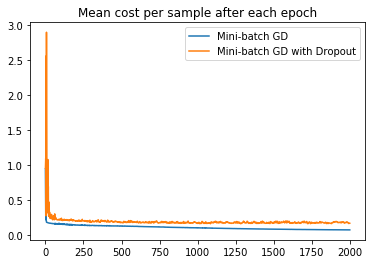

In [16]:
batch_size = 16
shape = (2,64,128,1)
alpha = 0.1
gamma = 0.0005
beta = 0.9
n_epoch = 2000

lam = 0
p = (1,0.5,0.5,1)

%time w_drop, b_drop, costs_drop = train_drop(X, yhat, shape, alpha, n_epoch, batch_size, beta, lam, p)
plt.plot(costs, label='Mini-batch GD')
plt.plot(costs_drop, label='Mini-batch GD with Dropout')
plt.legend()
plt.title('Mean cost per sample after each epoch');

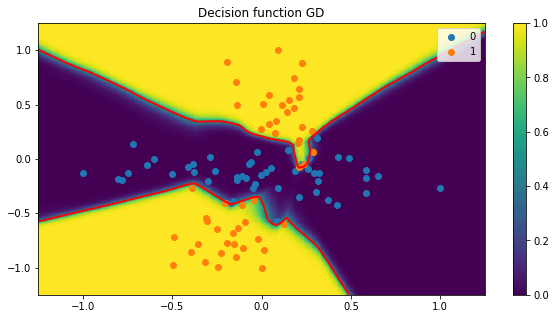

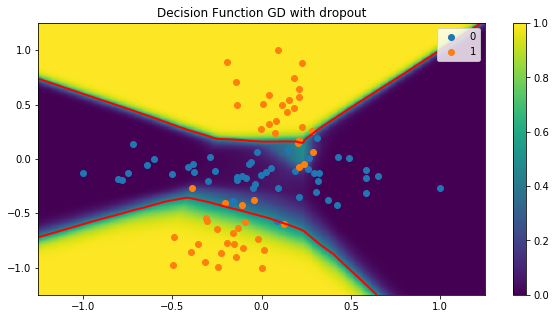

In [17]:
fun_map_drop = np.empty((x1.size, x2.size))
for n,i in enumerate(x1):
    for m,j in enumerate(x2):
        fun_map_drop[m,n] = forward_drop([i,-j], w_drop, b_drop, np.ones_like(shape))


plt.figure(figsize=(10,5))
plt.imshow(fun_map, extent=[x1.min(), x1.max(), x2.min(), x2.max()], 
           vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.contour(x1, -x2, fun_map, levels=[0.5], colors=['r'], label='Decision boundary', linewidths=2)
plt.scatter(*X0.T, label='0', alpha=1); plt.scatter(*X1.T, label='1', alpha=1)
plt.legend()
plt.title('Decision function GD')
plt.show();

plt.figure(figsize=(10,5))
plt.imshow(fun_map_drop, extent=[x1.min(), x1.max(), x2.min(), x2.max()], 
           vmin=0, vmax=1, aspect='auto')
plt.title('Decision Function GD with dropout')
plt.colorbar();
plt.contour(x1, -x2, fun_map_drop, levels=[0.5], colors=['r'], linewidths=2);
plt.scatter(*X0.T, label='0', alpha=1); plt.scatter(*X1.T, label='1', alpha=1)
plt.legend();

Much like with weight regularization, dropout causes the wiggles to largely be smoothed out. However, the gradients, especially along the top boundary, aren't nearly as shallow as when we did regularization, suggesting that the weights themselves aren't necessarily smaller. We also still see overfitting looming on the horizon, as a little island of yellow is beginning to surface near the center of the plot where the overfit "peninsula" sticks out of the unregularized decision function. Of course, this is not a silver bullet, and with enough epochs, overfitting is not to be completely avoided.

We can check our theory about the weights themselves by plotting their histograms:

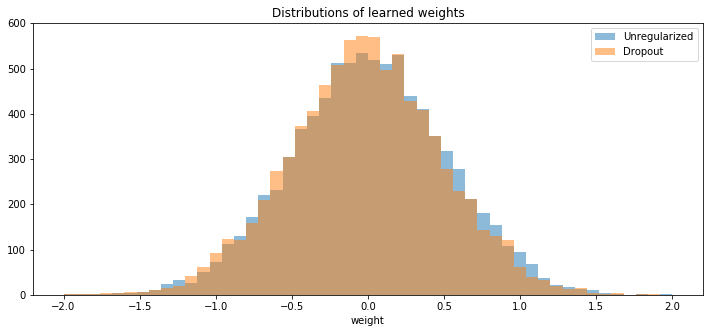

In [18]:
all_w_drop = np.hstack([w_drop[l].reshape(-1) for l in w_drop])

plt.figure(figsize=(12,5))
plt.hist(all_w, label='Unregularized', alpha=0.5, bins=50, range=(-2,2))
plt.hist(all_w_drop, label='Dropout', alpha=0.5, bins=50, range=(-2,2))
plt.title('Distributions of learned weights'); plt.xlabel('weight');
plt.legend();

Indeed the dropout weights are pretty much indistinguishable from the unregularized ones. Dropout has induced a more robust configuration, but has not reduced the magnitudes of the weights themselves. For this reason it's often a good idea to combine dropout with some form of direct weight regularization.